In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
!git clone https://github.com/Anjaas85/authentic_vs_AI_generated_photos


fatal: destination path 'authentic_vs_AI_generated_photos' already exists and is not an empty directory.


In [54]:
%cd authentic_vs_AI_generated_photos

/content/authentic_vs_AI_generated_photos


In [ ]:
!ls


checkpoints  data  logs  models  two_class_classification.ipynb  utils


In [ ]:
!git branch epochs20

In [ ]:
!git checkout epochs20

Switched to branch 'epochs20'


In [ ]:
# Downloading and Distributing the dataset
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split
import os
from PIL import Image

# Step 1: Define paths
data_root = "./data"
train_dir = os.path.join(data_root, "train")
val_dir = os.path.join(data_root, "val")
class_dirs = ["class_0", "class_1"]

# Step 2: Create folder structure
for directory in [train_dir, val_dir]:
    for class_dir in class_dirs:
        os.makedirs(os.path.join(directory, class_dir), exist_ok=True)

# Step 3: Download CIFAR10 dataset
cifar10 = CIFAR10(root="./", download=True)
data, labels = cifar10.data, cifar10.targets

# Step 4: Simulate CIFAKE10 (first 5 classes as "authentic", next 5 as "AI-generated")
labels = [0 if label < 5 else 1 for label in labels]

# Step 5: Split data into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

# Helper function to save images
def save_images(images, labels, save_dir):
    for idx, (image, label) in enumerate(zip(images, labels)):
        class_folder = os.path.join(save_dir, f"class_{label}")
        img = Image.fromarray(image)
        img.save(os.path.join(class_folder, f"{idx}.png"))

# Step 6: Save images to train and val folders
save_images(train_data, train_labels, train_dir)
save_images(val_data, val_labels, val_dir)

print("CIFAKE10 dataset distributed into train and validation folders.")




from models.densenet_model import create_densenet
from utils.data_loader import create_dataloaders, create_test_loader
from utils.evaluation import evaluate_model
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import json
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score
import numpy as np


# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths and parameters
data_dir = 'data'

# Load train, validation, and test data
dataloaders = create_dataloaders(data_dir, batch_size=32)
test_loader = create_test_loader( batch_size=32)

# Load model
model = create_densenet(num_classes=2).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Training function with extended metrics saving
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    metrics_file_path = os.path.join('metrics', 'metrics_by_epoch.txt')
    os.makedirs('metrics', exist_ok=True)

    # Initialize storage for metrics
    metrics_data = {
        "precision_recall": [],
        "f1_scores": [],
        "val_probs": [],
        "val_labels": [],
        "confusion_matrices": [],
        "epoch_metrics": []
    }

    with open(metrics_file_path, 'w') as f:
        f.write(f'Epoch\tPhase\tLoss\tAccuracy\n')

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0
                all_labels = []
                all_probs = []

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        probs = torch.softmax(outputs, dim=1)[:, 1]
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    all_labels.extend(labels.cpu().numpy().tolist())
                    all_probs.extend(probs.detach().cpu().numpy().tolist())

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                # Print and save metrics
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                f.write(f'{epoch+1}\t{phase}\t{epoch_loss:.4f}\t{epoch_acc:.4f}\n')

                # Save metrics for validation phase
                if phase == 'val':
                    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
                    f1 = f1_score(all_labels, np.round(all_probs))
                    confusion_mat = confusion_matrix(all_labels, np.round(all_probs))

                    metrics_data["precision_recall"].append({
                        "precision": precision.tolist(),
                        "recall": recall.tolist(),
                        "thresholds": thresholds.tolist(),
                    })
                    metrics_data["f1_scores"].append(float(f1))
                    metrics_data["val_probs"].append(all_probs)
                    metrics_data["val_labels"].append(all_labels)
                    metrics_data["confusion_matrices"].append(confusion_mat.tolist())

                    metrics_data["epoch_metrics"].append({
                        "epoch": epoch+1,
                        "loss": float(epoch_loss),
                        "accuracy": float(epoch_acc)
                    })

    # Save metrics data as JSON
    with open(os.path.join('metrics', 'metrics_data.json'), 'w') as json_file:
        json.dump(metrics_data, json_file, indent=4)

    print(f"Metrics saved in {metrics_file_path} and metrics_data.json")
    return model


# Train the model
trained_model = train_model(model, criterion, optimizer, dataloaders, num_epochs=20)



# Save the model
torch.save(trained_model.state_dict(), 'checkpoints/densenet_ai_vs_authentic.pth')
print("Model trained and saved!")

# Evaluate the model
print("Evaluating on validation set:")
evaluate_model(trained_model, dataloaders['val'], device,"validation")

print("Evaluating on test set:")
evaluate_model(trained_model, test_loader, device, "test")




100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting ./cifar-10-python.tar.gz to ./
CIFAKE10 dataset distributed into train and validation folders.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 192MB/s]


Epoch 1/20
----------
train Loss: 0.6551 Acc: 0.6136
val Loss: 0.6387 Acc: 0.6489
Epoch 2/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.6002 Acc: 0.6901
val Loss: 0.5825 Acc: 0.7093
Epoch 3/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5647 Acc: 0.7306
val Loss: 0.5520 Acc: 0.7444
Epoch 4/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5379 Acc: 0.7586
val Loss: 0.5328 Acc: 0.7673
Epoch 5/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5225 Acc: 0.7751
val Loss: 0.5060 Acc: 0.7924
Epoch 6/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5086 Acc: 0.7915
val Loss: 0.5075 Acc: 0.7864
Epoch 7/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4985 Acc: 0.8034
val Loss: 0.4822 Acc: 0.8183
Epoch 8/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4872 Acc: 0.8143
val Loss: 0.5047 Acc: 0.7975
Epoch 9/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4808 Acc: 0.8210
val Loss: 0.4810 Acc: 0.8194
Epoch 10/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4766 Acc: 0.8279
val Loss: 0.4694 Acc: 0.8348
Epoch 11/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4664 Acc: 0.8392
val Loss: 0.4640 Acc: 0.8386
Epoch 12/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4610 Acc: 0.8430
val Loss: 0.4627 Acc: 0.8407
Epoch 13/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4547 Acc: 0.8498
val Loss: 0.4579 Acc: 0.8472
Epoch 14/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4535 Acc: 0.8525
val Loss: 0.4569 Acc: 0.8458
Epoch 15/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4469 Acc: 0.8592
val Loss: 0.4446 Acc: 0.8611
Epoch 16/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4413 Acc: 0.8655
val Loss: 0.4429 Acc: 0.8633
Epoch 17/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4424 Acc: 0.8657
val Loss: 0.4455 Acc: 0.8598
Epoch 18/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4360 Acc: 0.8711
val Loss: 0.4443 Acc: 0.8604
Epoch 19/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4341 Acc: 0.8727
val Loss: 0.4371 Acc: 0.8673
Epoch 20/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4298 Acc: 0.8764
val Loss: 0.4388 Acc: 0.8688
Metrics saved in metrics/metrics_by_epoch.txt and metrics_data.json
Model trained and saved!
Evaluating on validation set:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5000
           1       0.87      0.86      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix:
[[4378  622]
 [ 690 4310]]
Evaluating on test set:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5000
           1       0.87      0.86      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix:
[[4362  638]
 [ 677 4323]]


In [ ]:
!git config --global user.email "anja.stanic2001@gmail.com"
!git config --global user.name "Anja Stanic"

In [ ]:
!git commit -m "First results for initial training on test and val"

In [ ]:
!git reset --soft HEAD~1


In [ ]:
!git reset

In [ ]:
!git log

In [ ]:
!git add new_main.ipynb

In [ ]:
!git add checkpoints/densenet_ai_vs_authentic.pth

In [ ]:
!git add utils/data_loader.py
!git add utils/evaluation.py
!git add models/densenet_model.py

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   checkpoints/densenet_ai_vs_authentic.pth

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.gitignore
	cifar-10-batches-py/
	cifar-10-python.tar.gz
	data/train/class_0/
	data/train/class_1/
	data/val/class_0/
	data/val/class_1/
	models/__pycache__/
	utils/__pycache__/



In [ ]:
!git commit -m "Result of inital training for val and test"

[main 7d673d2d] Result of inital training for val and test
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 checkpoints/densenet_ai_vs_authentic.pth


In [ ]:
!

#Some Visualizations

In [39]:
import pandas as pd

df = pd.read_csv('/content/authentic_vs_AI_generated_photos/metrics/metrics_by_epoch.txt', delimiter='\t')
df

,Epoch,Phase,Loss,Accuracy
0,1,train,0.6551,0.6136
1,1,val,0.6387,0.6489
2,2,train,0.6002,0.6901
3,2,val,0.5825,0.7093
4,3,train,0.5647,0.7306
5,3,val,0.5520,0.7444
6,4,train,0.5379,0.7586
7,4,val,0.5328,0.7673
8,5,train,0.5225,0.7751
9,5,val,0.5060,0.7924


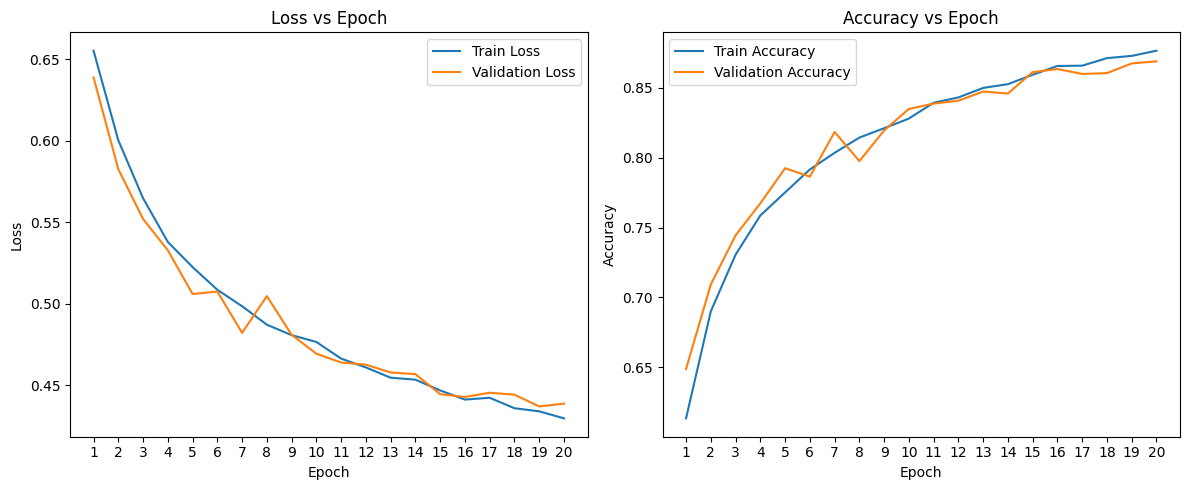

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

#plotting loss
plt.subplot(1, 2, 1)
plt.plot(df[df['Phase'] == 'train']['Epoch'], df[df['Phase'] == 'train']['Loss'], label='Train Loss')
plt.plot(df[df['Phase'] == 'val']['Epoch'], df[df['Phase'] == 'val']['Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.xticks(df['Epoch'].unique())


#plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(df[df['Phase'] == 'train']['Epoch'], df[df['Phase'] == 'train']['Accuracy'], label='Train Accuracy')
plt.plot(df[df['Phase'] == 'val']['Epoch'], df[df['Phase'] == 'val']['Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.xticks(df['Epoch'].unique())

plt.tight_layout()
plt.show()

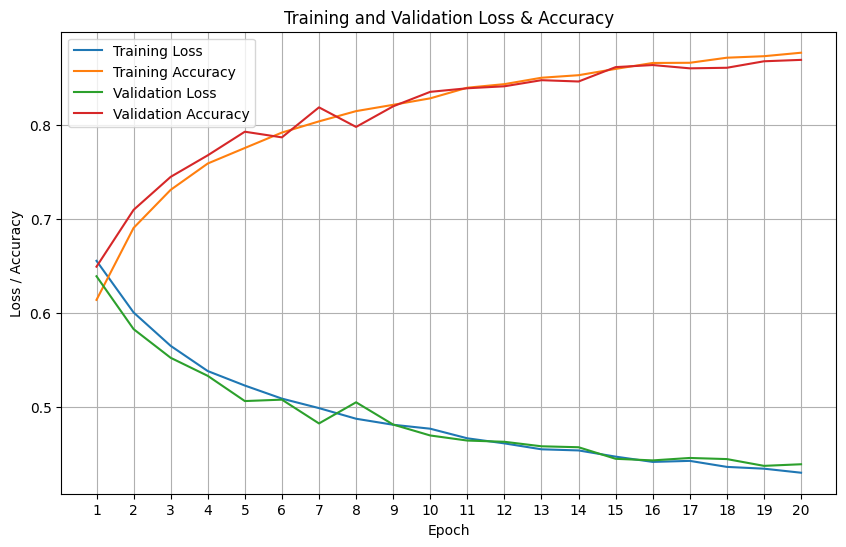

In [43]:
train_df = df[df['Phase'] == 'train']
val_df = df[df['Phase'] == 'val']

plt.figure(figsize=(10, 6))

#training loss and accuracy
plt.plot(train_df['Epoch'], train_df['Loss'], label='Training Loss')
plt.plot(train_df['Epoch'], train_df['Accuracy'], label='Training Accuracy')

#validation loss and accuracy
plt.plot(val_df['Epoch'], val_df['Loss'], label='Validation Loss')
plt.plot(val_df['Epoch'], val_df['Accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Loss & Accuracy')
plt.legend()
plt.xticks(df['Epoch'].unique())
plt.grid(True)
plt.show()

In [45]:
!cat /content/authentic_vs_AI_generated_photos/metrics/metrics.txt

Phase: validation
Classification Report:
Class 0:
  precision: 0.8639
  recall: 0.8756
  f1-score: 0.8697
  support: 5000.0000
Class 1:
  precision: 0.8739
  recall: 0.8620
  f1-score: 0.8679
  support: 5000.0000
Class macro avg:
  precision: 0.8689
  recall: 0.8688
  f1-score: 0.8688
  support: 10000.0000
Class weighted avg:
  precision: 0.8689
  recall: 0.8688
  f1-score: 0.8688
  support: 10000.0000

Confusion Matrix:
[[4378  622]
 [ 690 4310]]
Phase: test
Classification Report:
Class 0:
  precision: 0.8656
  recall: 0.8724
  f1-score: 0.8690
  support: 5000.0000
Class 1:
  precision: 0.8714
  recall: 0.8646
  f1-score: 0.8680
  support: 5000.0000
Class macro avg:
  precision: 0.8685
  recall: 0.8685
  f1-score: 0.8685
  support: 10000.0000
Class weighted avg:
  precision: 0.8685
  recall: 0.8685
  f1-score: 0.8685
  support: 10000.0000

Confusion Matrix:
[[4362  638]
 [ 677 4323]]


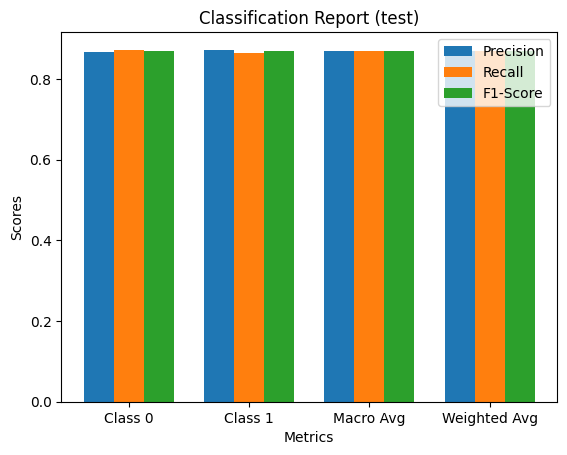

In [48]:
#classification report data
labels = ['Class 0', 'Class 1', 'Macro Avg', 'Weighted Avg']
precision = [0.8656, 0.8714, 0.8685, 0.8685]
recall = [0.8724, 0.8646, 0.8685, 0.8685]
f1_score = [0.8690, 0.8680, 0.8685, 0.8685]

x = np.arange(len(labels))

width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Classification Report (test)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


The metrics for both classes are quite consistent, indicating balanced performance across classes.

The Macro Average and Weighted Average metrics are also consistent with the individual class metrics, suggesting that the model performs uniformly well across different classes.

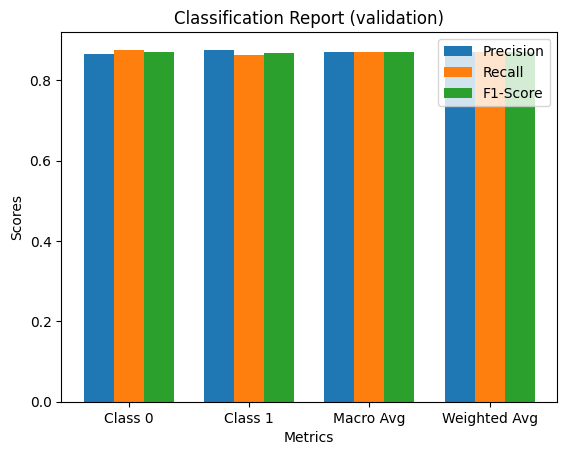

In [52]:
#classification report data
labels = ['Class 0', 'Class 1', 'Macro Avg', 'Weighted Avg']
precision = [0.8639, 0.8739, 0.8689, 0.8689]
recall = [0.8756, 0.8620, 0.8688, 0.8688]
f1_score = [0.8697, 0.8679, 0.8688, 0.8688]

x = np.arange(len(labels))

width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Classification Report (validation)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


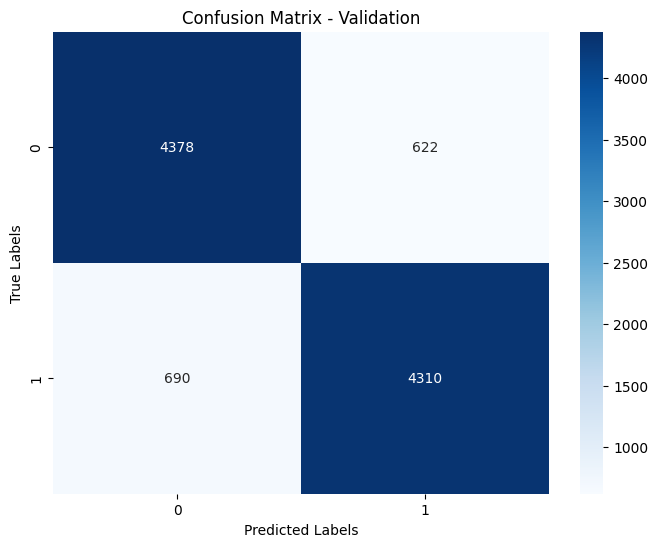

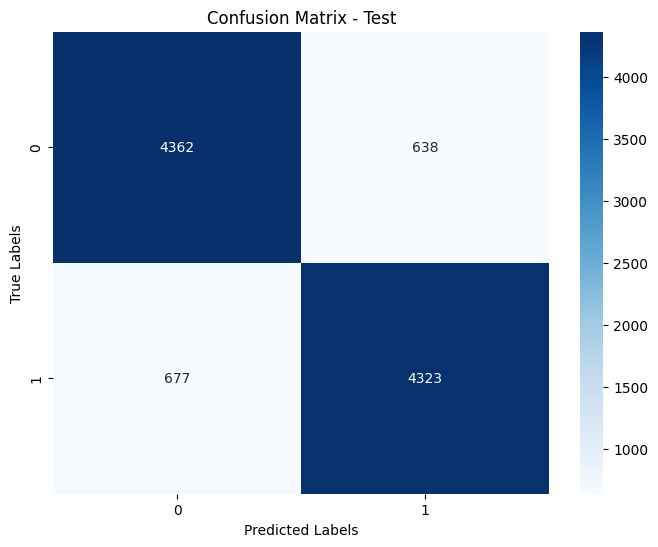

In [50]:
import seaborn as sns

conf_matrix_val = np.array([[4378, 622], [690, 4310]])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Validation')
plt.show()

conf_matrix_test = np.array([[4362, 638], [677, 4323]])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test')
plt.show()


In [70]:
import json
with open('/content/authentic_vs_AI_generated_photos/metrics/metrics_data.json', 'r') as f:
    metrics_data = json.load(f)

In [72]:
metrics_data['epoch_metrics']

[{'epoch': 1, 'loss': 0.6387455700874328, 'accuracy': 0.6489},
 {'epoch': 2, 'loss': 0.5824644403457642, 'accuracy': 0.7093},
 {'epoch': 3, 'loss': 0.5520129545211792, 'accuracy': 0.7444000000000001},
 {'epoch': 4, 'loss': 0.5327886512756348, 'accuracy': 0.7673},
 {'epoch': 5, 'loss': 0.5060010207176209, 'accuracy': 0.7924},
 {'epoch': 6, 'loss': 0.5074801582336426, 'accuracy': 0.7864},
 {'epoch': 7, 'loss': 0.4821979920387268, 'accuracy': 0.8183},
 {'epoch': 8, 'loss': 0.50470498046875, 'accuracy': 0.7975},
 {'epoch': 9, 'loss': 0.481019575881958, 'accuracy': 0.8194},
 {'epoch': 10, 'loss': 0.46943684329986574, 'accuracy': 0.8348},
 {'epoch': 11, 'loss': 0.4639588840484619, 'accuracy': 0.8386},
 {'epoch': 12, 'loss': 0.4627477699279785, 'accuracy': 0.8407},
 {'epoch': 13, 'loss': 0.45785962858200074, 'accuracy': 0.8472000000000001},
 {'epoch': 14, 'loss': 0.45685059452056886, 'accuracy': 0.8458},
 {'epoch': 15, 'loss': 0.44456686191558836, 'accuracy': 0.8611000000000001},
 {'epoch': 1

In [76]:
metrics_data['confusion_matrices']

[[[2836, 2164], [1347, 3653]],
 [[3204, 1796], [1111, 3889]],
 [[4357, 643], [1913, 3087]],
 [[3693, 1307], [1020, 3980]],
 [[3793, 1207], [869, 4131]],
 [[4486, 514], [1622, 3378]],
 [[4189, 811], [1006, 3994]],
 [[3812, 1188], [837, 4163]],
 [[4274, 726], [1080, 3920]],
 [[4223, 777], [875, 4125]],
 [[4127, 873], [741, 4259]],
 [[4421, 579], [1014, 3986]],
 [[4377, 623], [905, 4095]],
 [[4370, 630], [912, 4088]],
 [[4350, 650], [739, 4261]],
 [[4392, 608], [759, 4241]],
 [[4258, 742], [660, 4340]],
 [[4192, 808], [588, 4412]],
 [[4354, 646], [681, 4319]],
 [[4378, 622], [690, 4310]]]

In [81]:
for i in metrics_data:
  print(i)

precision_recall
f1_scores
val_probs
val_labels
confusion_matrices
epoch_metrics


In [94]:
for i in metrics_data['precision_recall'][0]:
  print(i)

precision
recall
thresholds


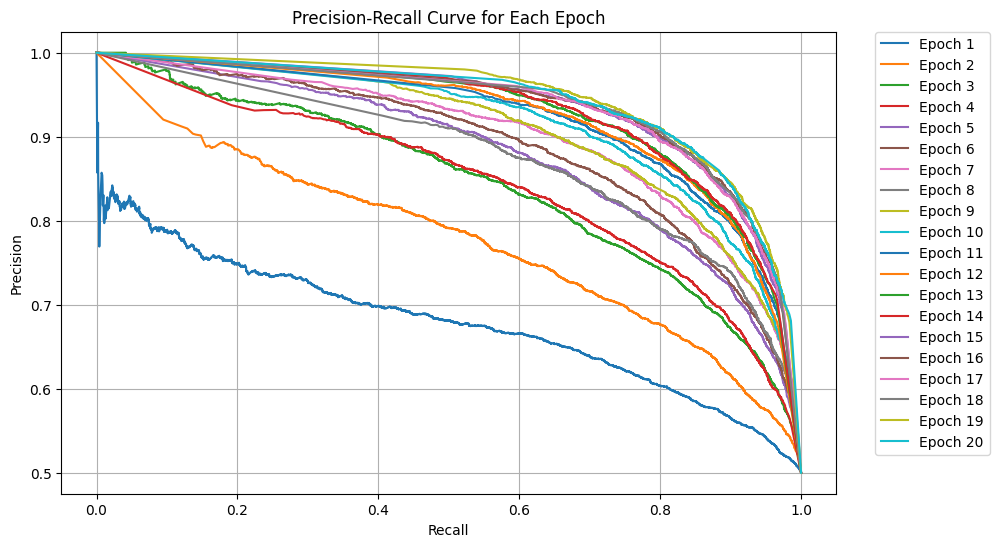

In [104]:
precision_recall_data = metrics_data["precision_recall"]

plt.figure(figsize=(10, 6))

for i, data in enumerate(precision_recall_data):
    plt.plot(data["recall"], data["precision"], label=f"Epoch {i+1}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()

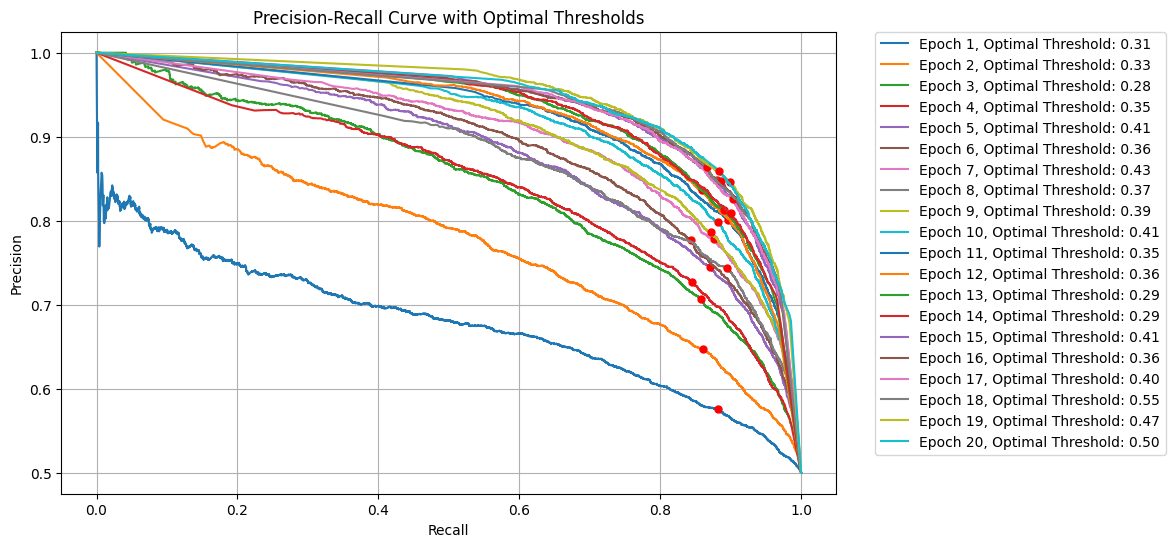

In [105]:
# Extract precision, recall, and thresholds for each epoch
precision_recall_data = metrics_data["precision_recall"]

plt.figure(figsize=(10, 6))

for i, data in enumerate(precision_recall_data):
    precision = data["precision"]
    recall = data["recall"]
    thresholds = data["thresholds"]

    #finding the threshold that maximizes F1-score
    f1_scores = 2 * np.array(precision) * np.array(recall) / (np.array(precision) + np.array(recall))
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    #adding the optimal threshold on the plot
    plt.plot(recall, precision, label=f"Epoch {i+1}, Optimal Threshold: {optimal_threshold:.2f}")
    plt.plot(recall[optimal_idx], precision[optimal_idx], marker='o', markersize=5, color='red')


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Optimal Thresholds")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()

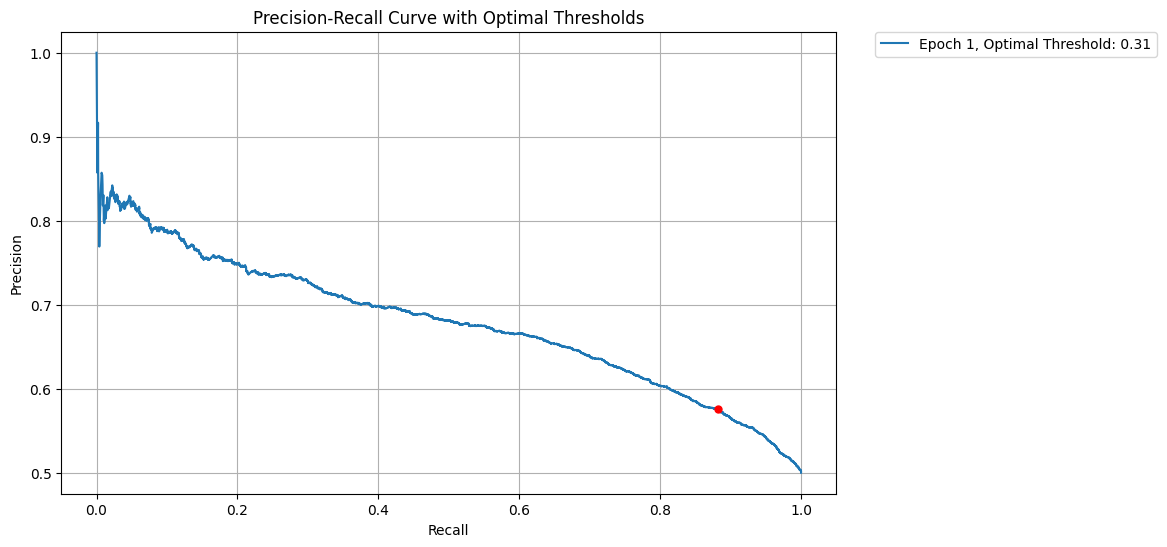

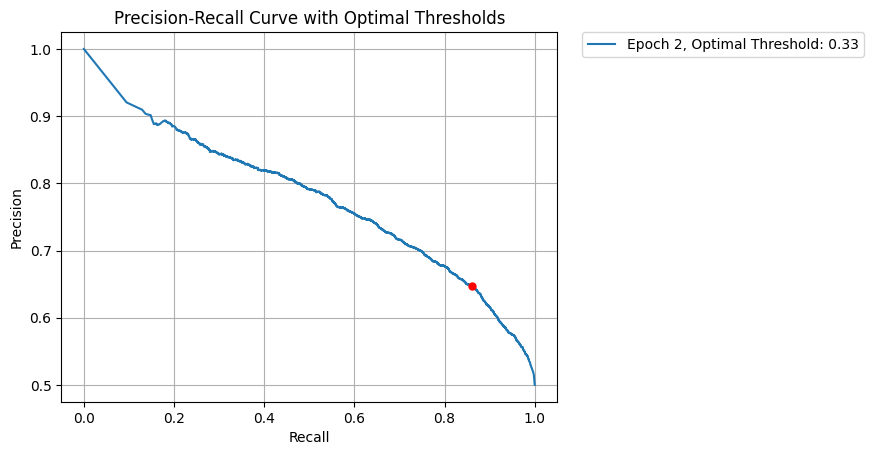

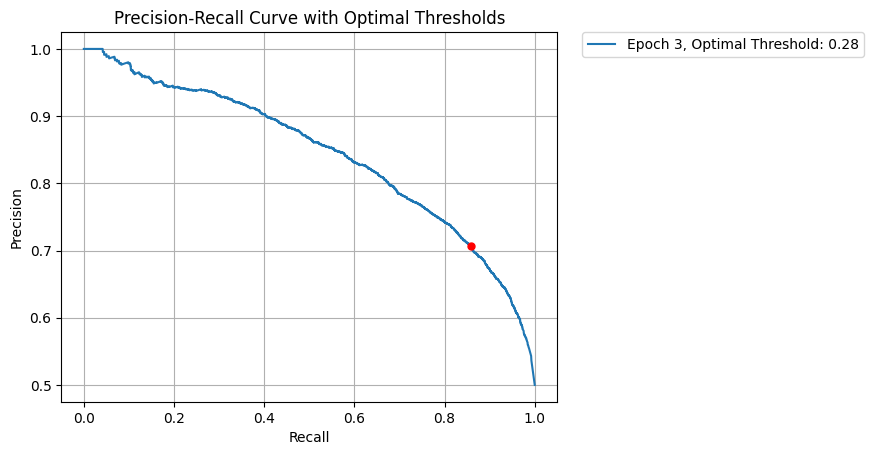

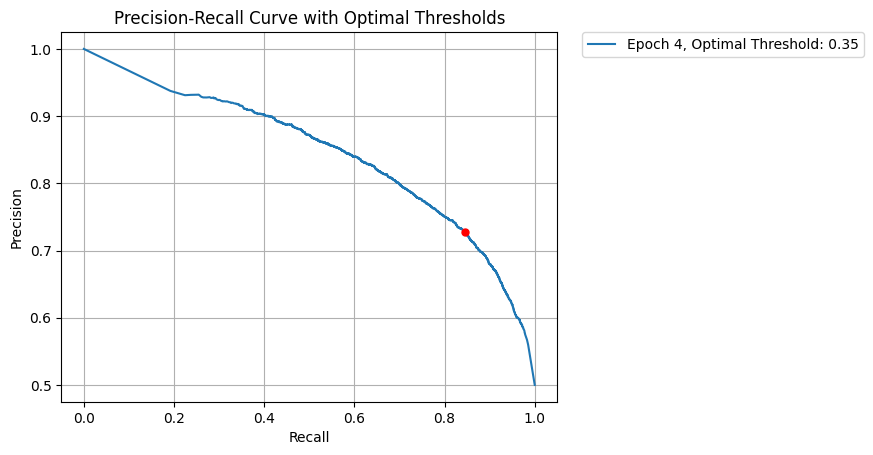

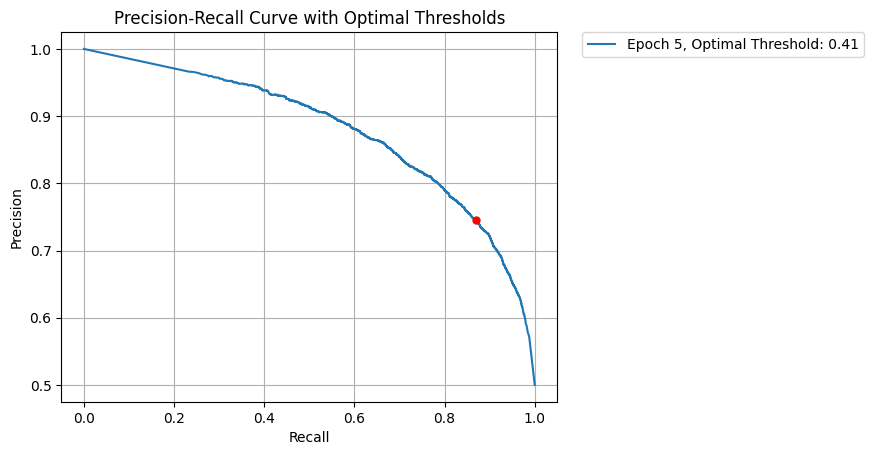

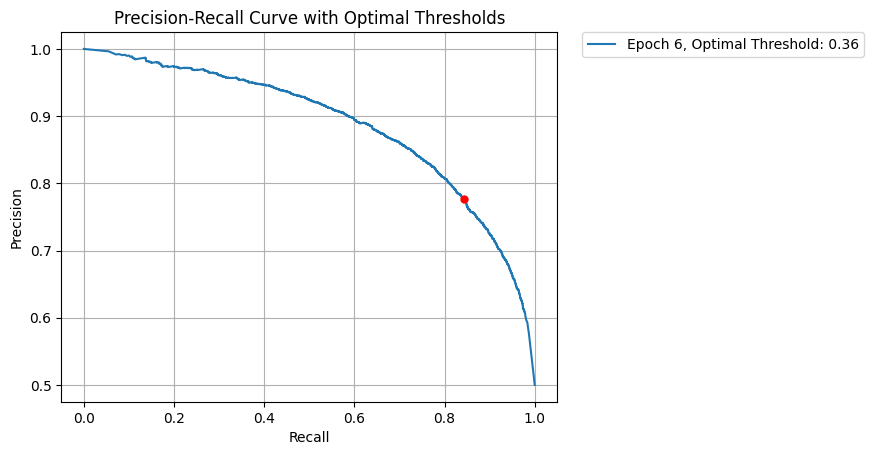

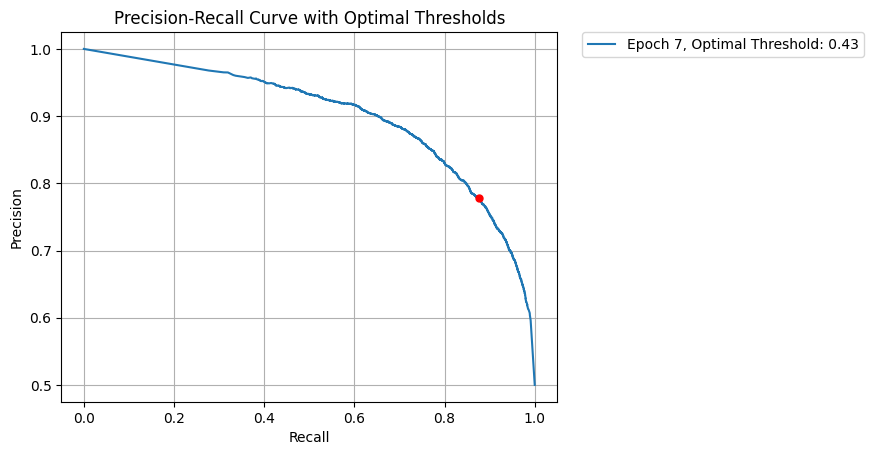

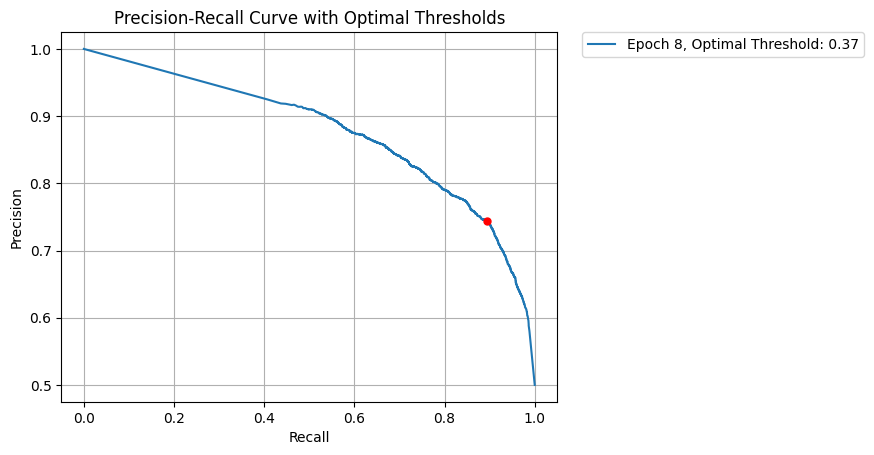

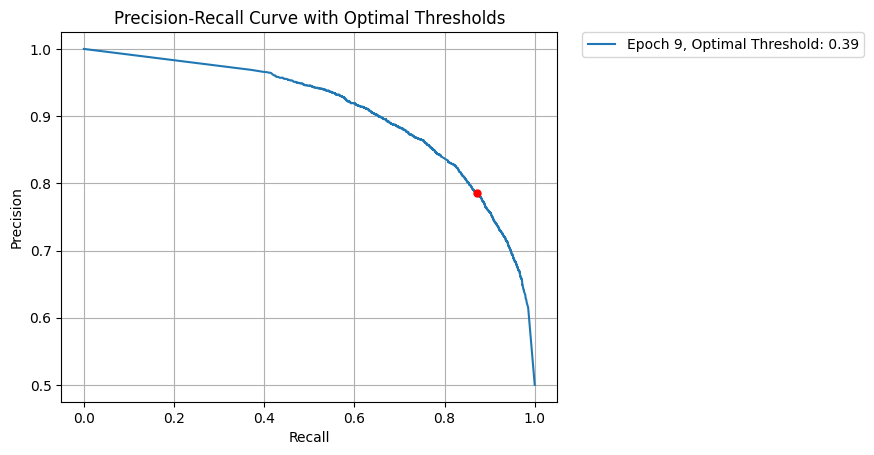

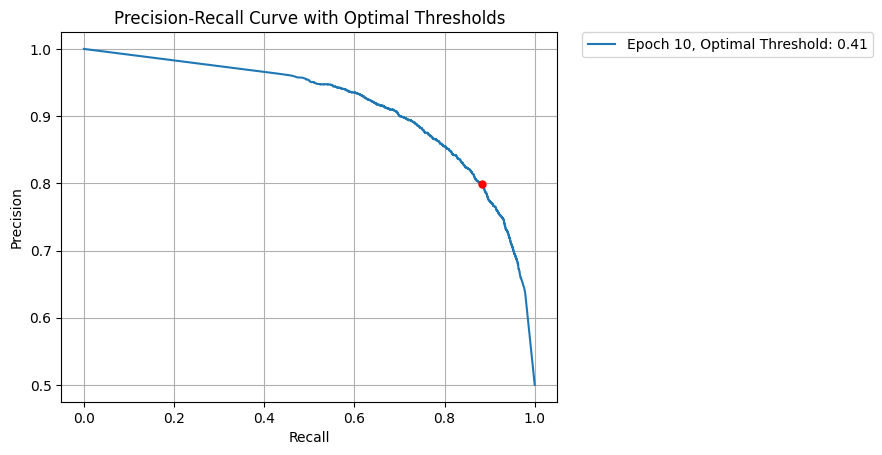

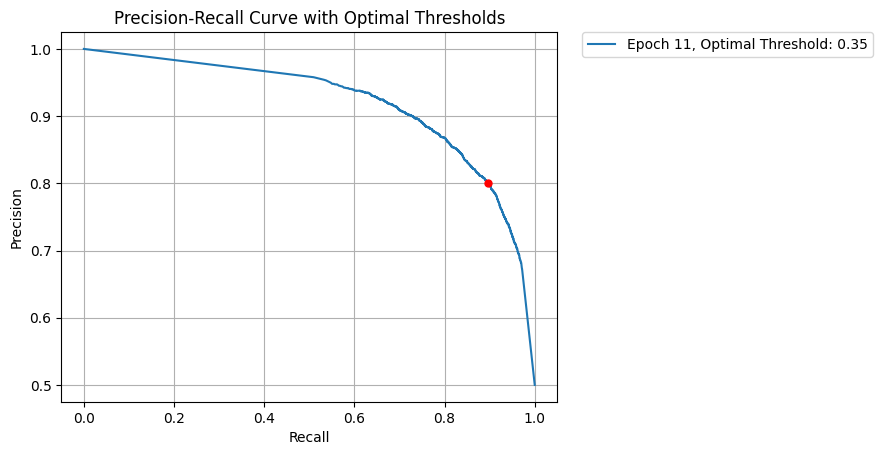

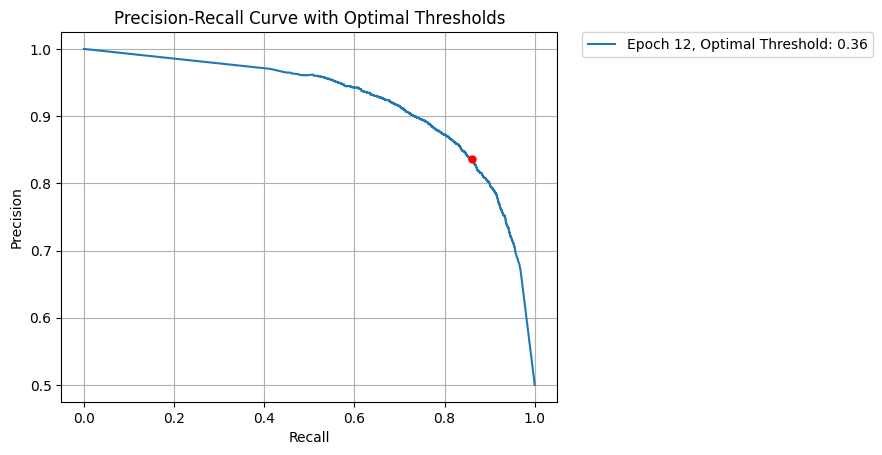

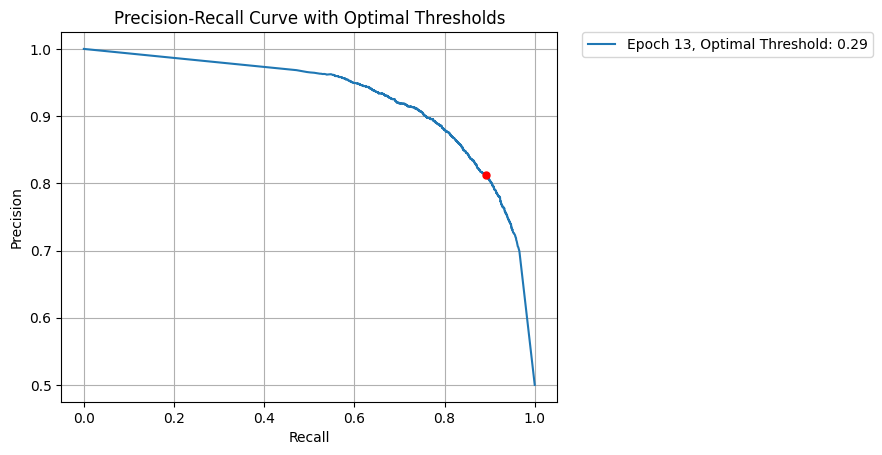

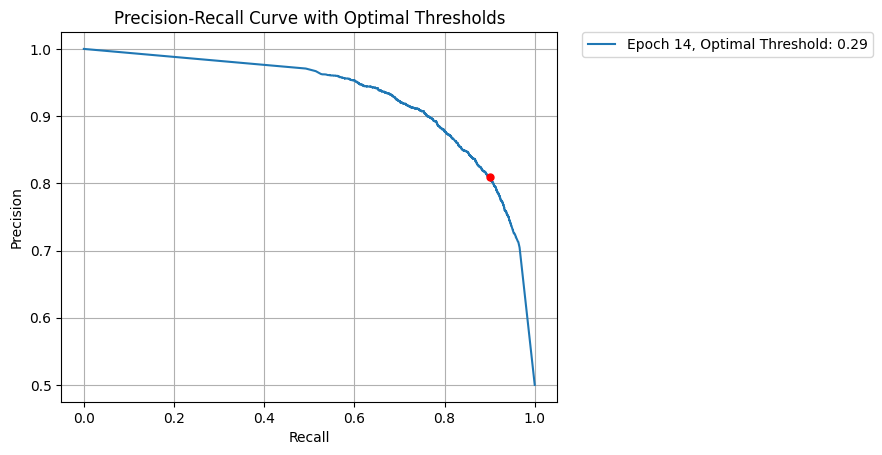

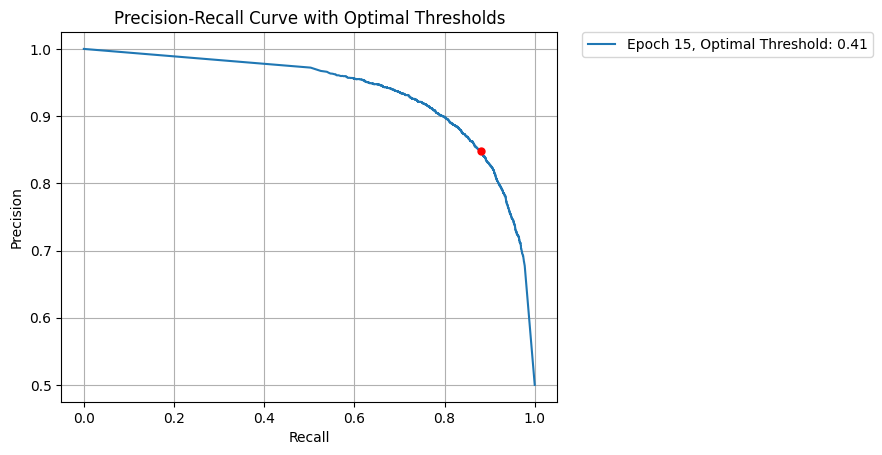

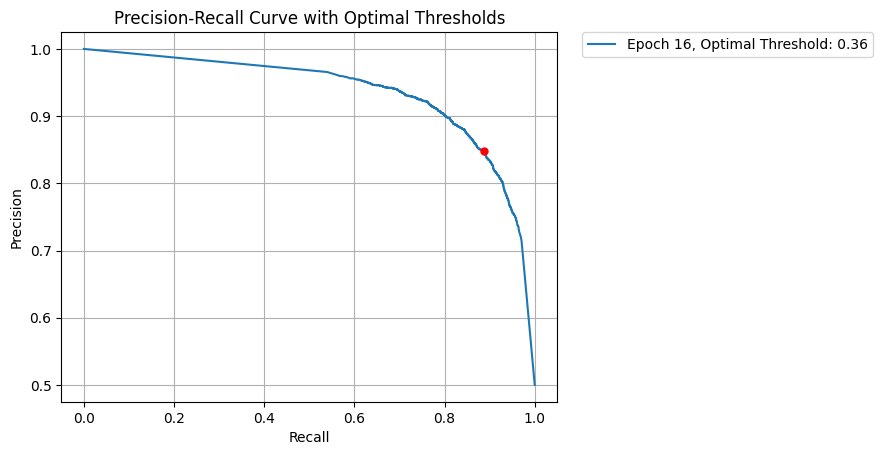

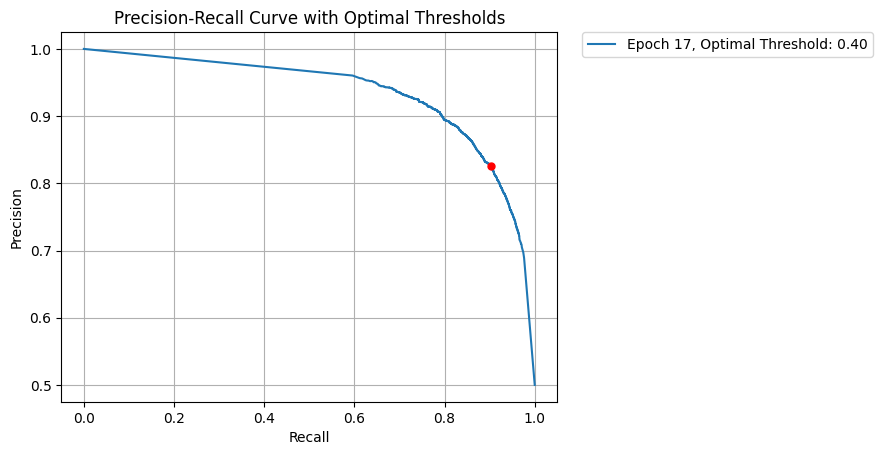

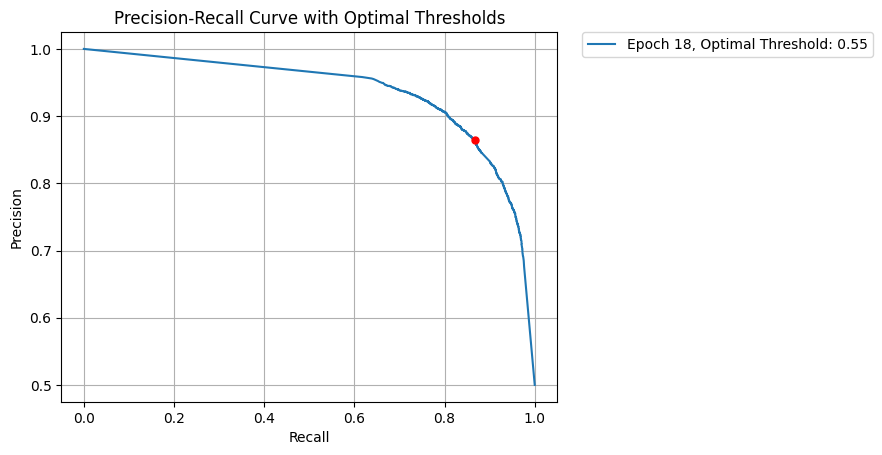

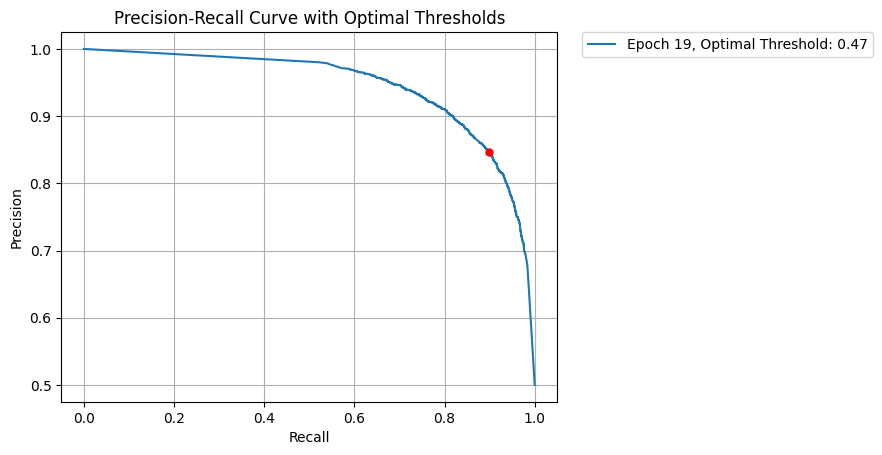

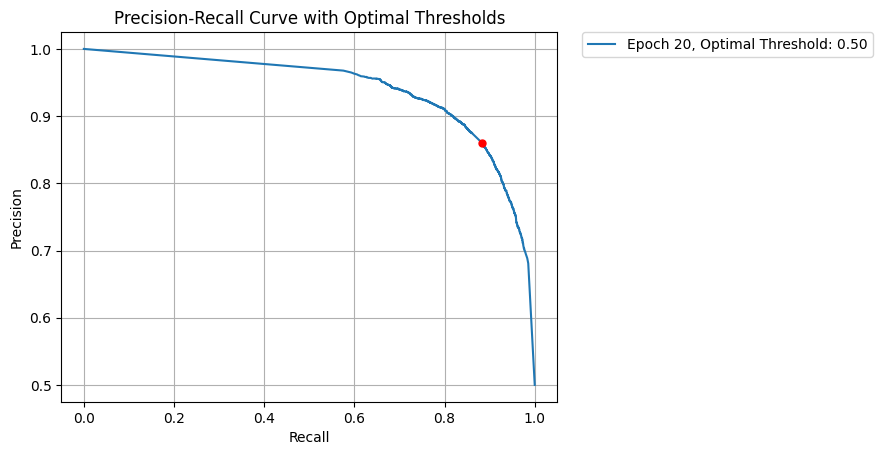

In [106]:
# Extract precision, recall, and thresholds for each epoch
precision_recall_data = metrics_data["precision_recall"]

plt.figure(figsize=(10, 6))

for i, data in enumerate(precision_recall_data):
    precision = data["precision"]
    recall = data["recall"]
    thresholds = data["thresholds"]

    #finding the threshold that maximizes F1-score
    f1_scores = 2 * np.array(precision) * np.array(recall) / (np.array(precision) + np.array(recall))
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    #adding the optimal threshold on the plot
    plt.plot(recall, precision, label=f"Epoch {i+1}, Optimal Threshold: {optimal_threshold:.2f}")
    plt.plot(recall[optimal_idx], precision[optimal_idx], marker='o', markersize=5, color='red')


    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve with Optimal Thresholds")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.show()